In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import re
import os
import pickle
from wordcloud import WordCloud
import string
from gensim.models import Word2Vec
stopwords = stopwords.words('english')

In [2]:
import gensim.downloader
from gensim.models import KeyedVectors

# Load the model from gensim-data
model = gensim.downloader.load('glove-twitter-200')
# save the model to disk
model.save('glove-twitter-200.kv')

# load the model from disk
model = KeyedVectors.load('glove-twitter-200.kv')

[==================================================] 100.0% 758.5/758.5MB downloaded


In [3]:
from gensim.models import KeyedVectors
# load the model from disk
model = KeyedVectors.load('glove-twitter-200.kv')

In [4]:
# Importing the dataset
tweets = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='utf-8',header=None)
tweets.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
tweets.columns = ['sentiment','id','date','query_string','user','text']
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   sentiment     1600000 non-null  int64 
 1   id            1600000 non-null  int64 
 2   date          1600000 non-null  object
 3   query_string  1600000 non-null  object
 4   user          1600000 non-null  object
 5   text          1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
tweets.drop(['id','date','query_string','user'],inplace=True,axis=1)
tweets['sentiment'].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [7]:
# Convert the 4 into 1 (positive sentiment)
tweets['sentiment'] = tweets['sentiment'].map({0: 0, 4: 1})
tweets['sentiment'].value_counts()

0    800000
1    800000
Name: sentiment, dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

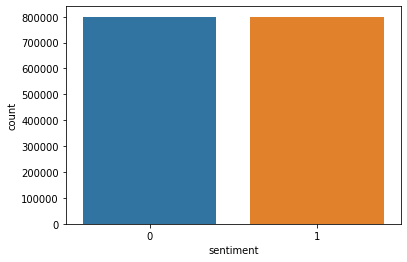

In [8]:
# Visualising the distribution and the wordcloud of sentiments
sns.countplot(data=tweets,x='sentiment')

In [9]:
# processing data now
tweets

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [10]:
#1. convert to lowercase
#2. remove @usernames
#3. remove links
#4. remove special characters
#5. remove stopwords
#6. lemmatize the words
#7. remove punctuations
#8. remove repeating characters
#9. remove words with length <= 2
#10. remove numbers

lemmatizer = WordNetLemmatizer()
english_punctuations = string.punctuation
translator = str.maketrans('','',english_punctuations)

def clean_text(text):
    text = text.lower()
    text = " ".join([word for word in str(text).split() if word not in stopwords])
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
    text = re.sub('[\w]+\.com',' ',text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = re.sub('[0-9]+','',text)
    text = re.sub('@[^\s]+',' ',text)
    text = text.translate(translator)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = ' '.join([word for word in text.split() if len(word)>2])
    return text

tweets['clean_text'] = tweets['text'].apply(lambda x: clean_text(x))


In [11]:
tweets['clean_text']

0          aww thats bummer shoulda got david carr third day
1          upset cant update facebook texting might cry r...
2             dived many times ball managed save rest bounds
3                           whole body feels itchy like fire
4                       behaving all mad here cant see there
                                 ...                        
1599995                        woke school best feeling ever
1599996                        cool hear old walt interviews
1599997                      ready mojo makeover ask details
1599998       happy birthday boo all time tupac amaru shakur
1599999                                 happy charitytuesday
Name: clean_text, Length: 1600000, dtype: object

In [12]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\s+',gaps=True)
tweets['clean_text'] = tweets['clean_text'].apply(tokenizer.tokenize)
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [13]:
tweets['clean_text']

0          [aww, thats, bummer, shoulda, got, david, carr...
1          [upset, cant, update, facebook, texting, might...
2          [dived, many, time, ball, managed, save, rest,...
3                     [whole, body, feel, itchy, like, fire]
4               [behaving, all, mad, here, cant, see, there]
                                 ...                        
1599995                  [woke, school, best, feeling, ever]
1599996                   [cool, hear, old, walt, interview]
1599997                 [ready, mojo, makeover, ask, detail]
1599998    [happy, birthday, boo, all, time, tupac, amaru...
1599999                              [happy, charitytuesday]
Name: clean_text, Length: 1600000, dtype: object

In [14]:
# find number of unique words
unique_words = set()
for text in tweets['clean_text']:
    for word in text:
        unique_words.add(word)

print(len(unique_words))

383840


In [15]:
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: ' '.join(x))
tweets

,sentiment,text,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww thats bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,0,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save rest bound
3,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving all mad here cant see there
...,...,...,...
1599995,1,Just woke up. Having no school is the best fee...,woke school best feeling ever
1599996,1,TheWDB.com - Very cool to hear old Walt interv...,cool hear old walt interview
1599997,1,Are you ready for your MoJo Makeover? Ask me f...,ready mojo makeover ask detail
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...,happy birthday boo all time tupac amaru shakur


In [16]:
max_len = 20
tokenizer_keras = Tokenizer()
tokenizer_keras.fit_on_texts(tweets['clean_text'].values)
X = tokenizer_keras.texts_to_sequences(tweets['clean_text'].values)
X = pad_sequences(X, maxlen=max_len, padding='post')
y = tweets['sentiment'].values

In [23]:
# Splitting dataset into train, test and validation
train_ratio = 0.7
validation_ratio = 0.2
test_ratio = 0.1

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=1-train_ratio, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1119999, 20)
(160001, 20)
(320000, 20)


In [18]:
embedding_dim = 200
max_features = len(tokenizer_keras.word_index)+1
word_index = tokenizer_keras.word_index
embedding_matrix = np.zeros((max_features, embedding_dim))

for word, i in word_index.items():
    if word in model:
        embedding_matrix[i] = model[word]

embedding_matrix.shape

(383841, 200)

In [24]:
# Building the LSTM classifier
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.regularizers import L2

lstm_out = 300

gpu = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpu[0], 'GPU')
print("Num GPUs Available: ", len(gpu))

with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=L2(0.00001), return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Conv1D(100, kernel_size=3, activation='relu',kernel_regularizer=L2(0.00001)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu', kernel_regularizer=L2(0.00001)))
    model.add(Dropout(0.4))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=Adam(learning_rate=0.0001),metrics = ['accuracy'])

model.summary()

Num GPUs Available:  1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 200)           76768200  
                                                                 
 dropout_3 (Dropout)         (None, 20, 200)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 600)          1202400   
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 20, 600)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 100)           180100    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 100)              0         
 balMaxPooling1D)              

In [25]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    restore_best_weights=True
)

history = model.fit(X_train, y_train, epochs=200, batch_size=1024, validation_data=(X_val,y_val),callbacks=[earlystopping])

Batch Size:  64 

Epoch 1/10
17500/17500 [==============================] - 2465s 141ms/step - loss: 0.5335 - accuracy: 0.7368 - val_loss: 0.4803 - val_accuracy: 0.7750
Epoch 2/10
17500/17500 [==============================] - 2440s 139ms/step - loss: 0.5057 - accuracy: 0.7564 - val_loss: 0.4704 - val_accuracy: 0.7801
Epoch 3/10
17500/17500 [==============================] - 2438s 139ms/step - loss: 0.4961 - accuracy: 0.7634 - val_loss: 0.4644 - val_accuracy: 0.7839
Epoch 4/10
17500/17500 [==============================] - 2441s 139ms/step - loss: 0.4906 - accuracy: 0.7671 - val_loss: 0.4609 - val_accuracy: 0.7857
Epoch 5/10
17500/17500 [==============================] - 2440s 139ms/step - loss: 0.4861 - accuracy: 0.7707 - val_loss: 0.4581 - val_accuracy: 0.7880
Epoch 6/10
17500/17500 [==============================] - 2443s 140ms/step - loss: 0.4828 - accuracy: 0.7727 - val_loss: 0.4552 - val_accuracy: 0.7902
Epoch 7/10
17500/17500 [==============================] - 2442s 140ms/step -

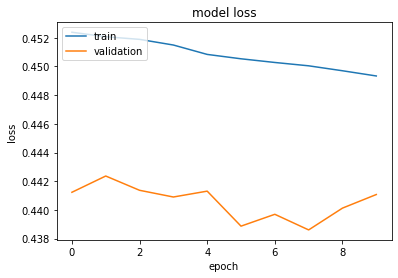

In [26]:
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [27]:
best_batch_size

1024

157/157 - 4s - loss: 0.4392 - accuracy: 0.8004 - 4s/epoch - 27ms/step
score: 0.44
accuracy: 0.80
5001/5001 [==============================] - 92s 18ms/step


<Axes: >

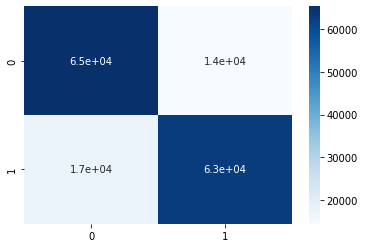

In [31]:
score, acc = model.evaluate(X_test, y_test, verbose=2, batch_size=1024)
print("score: %.2f" % (score))
print("accuracy: %.2f" % (acc))
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)
cfm = confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, annot=True, cmap='Blues')